In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    "Improvement",
    #"Solved",
    #"AreaRatio",
    #"Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

train_samples = os.path.join(cwd, "data", "train") # 116586 + 489623 = 606209
test_samples = os.path.join(cwd, "data", "validation")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "validation",
    follow_links = False
)



Found 489623 files belonging to 1 classes.
Using 440661 files for training.


2024-02-03 15:56:54.360081: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-03 15:56:54.360118: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-03 15:56:54.360121: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-03 15:56:54.360160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-03 15:56:54.360176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 489623 files belonging to 1 classes.
Using 48962 files for validation.


In [4]:
for X in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: B
instance: MA2
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P355037001
Stack 0 with items: ['0090016200_26102022000265', '0090016200_26102022000255']
Stack 1 with items: ['0090016200_26102022012372', '0090016200_26102022012372', '0090016200_26102022017816']
Stack 2 with items: ['0090016200_26102022006635', '0090016200_26102022002470', '0090016200_26102022013378']
Stack 3 with items: ['0090016200_26102022015271', '0090016200_26102022007589', '0090016200_26102022015271']
Stack 4 with items: ['0090016200_26102022001327', '0090016200_26102022001327']
Stack 5 with items: ['0090016200_26102022015678', '0090016200_26102022004493', '0090016200_26102022015678']
Stack 6 with items: ['0090016200_26102022019753', '0090016200_26102022019604', '0090016200_26102022019753']
Stack 7 with items: ['0090016200_26102022016002', '0090016200_26102022016002', '0090016200_26102022016002']
Stack 8 with items: ['0090016200_26102022012624', '0090016200_26102022012624', '0090016200_261020

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

Supplier code,Supplier dock,Plant dock,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth
i64,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool
679301,null,"""169GB-20""",2.4,1.2,1.9,0.518208,0.045,"""C""","""BY""","""0090016900_270…",false,false
2695000,null,"""GRF1""",2.4,1.2,0.76,0.243,0.045,"""C""","""BY""","""0090016900_270…",false,false
679301,null,"""169GB-20""",2.4,1.2,1.62,0.457104,0.045,"""C""","""BY""","""0090016900_270…",false,false
27029901,null,"""GRE1""",1.206,1.01,0.485,0.028632,0.0,"""C""","""BY""","""0090016900_270…",false,false
6681302,null,"""169GD-60""",1.206,1.01,1.093,0.08744,0.0,"""C""","""BY""","""0090016900_270…",false,false
23676300,null,"""169GD-60""",2.4,2.2,1.52,0.5944,0.045,"""C""","""BY""","""0090016900_270…",false,false
90016100,"""K11""","""GRD1""",2.3,1.6,1.0,1.57,0.045,"""C""","""BY""","""0090016900_270…",false,false
201500,null,"""169GD-60""",2.0,1.34,1.13,0.15804,0.045,"""C""","""BY""","""0090016900_270…",false,false
679301,null,"""169GB-20""",2.4,1.2,2.0,0.58,0.045,"""C""","""BY""","""0090016900_270…",false,false


In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62069600,1,null,1,"""X1""",1,"""P187730503""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P187731005""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P188730503""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P192730403""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P193731303""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P194730405""","""A""","""AS"""
29938000,1,null,1,"""X3""",1,"""P195709601""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P195730503""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P195731001""","""A""","""AS"""


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187730405""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187730501""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187731001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187731305""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189721903""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730405""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192709601""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192730503""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192731001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import input_output_generation

In [9]:
cx, cy = input_output_generation(
    X,
    #target_labels=TARGET_LABELS,
    pad_size=PAD_SIZE,
    shuffle=False,
    items=items,
    truck_stops=truck_stops,
    truck_dims=truck_dims,
)

In [10]:
cx[0][0, :40]

array([[ 1.2       ,  1.        ,  0.37984   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.424516  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.577192  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.252146  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.377846  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.206     ,  1.01      ,  0.2851    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.3985    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.07856   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.420

# DNN

### Optimizer, Losses and Metrics

In [11]:
# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

In [12]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = cy[0].mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = cy[1].mean(),
    name='improvement_focal_loss'
)

loss_area_ratio = tf.keras.losses.BinaryCrossentropy(
    name='area_ratio_crossentropy'
)



loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = cy[-1].mean(),
    name='stacks_focal_loss'
)

for i, target in enumerate(TARGET_LABELS):
    print(f"{target} Prevalence: {cy[i].mean():.1%}")

Improvement Prevalence: 37.9%


In [13]:
target_loss_objects = {
    "Solved": loss_solved,
    "Improvement": loss_improvement,
    "AreaRatio": loss_area_ratio,
    "Stacks": loss_stacks,
}

loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [14]:
all_target_metrics: list[list[tf.keras.metrics]] = {
    "Solved": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "Improvement": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "AreaRatio": [
        keras.metrics.RootMeanSquaredError(name="RMSE"),
        keras.metrics.MeanAbsoluteError(name="MAE")
    ],
    "Stacks": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
}

all_metrics = [all_target_metrics[target] for target in TARGET_LABELS]

## Architecture

In [15]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder



def build_model(
    # input data dependent
    target_labels: list[str]=["Improvement"],
    n_features: int=9,
    pad_size: int=80,

    # hyperparameters in descending relevance
    n_blocks: int=3,
    num_heads: int=3,
    upscale_factor: float=1,
    encoder_dropout: float=0.1,
    activation: str="gelu", # "relu" "gelu" "selu" "swish"
    
    # additional experimental features
    use_bias: bool=True,
    split_last_layer: bool=False,
    use_PreLN: bool=True,
    bias_regularizer=None,
) -> Model:
    """
    Creates the encoder model according to the hyperparamters.
    """

    # Input
    input_stack_level = Input(shape=(pad_size, n_features), name="StackLevelInputFeatures", dtype=tf.float16,)
    input_time_limit = Input(shape=(1), name="TimeLimitInput", dtype=tf.float16,)
    inputs = [input_stack_level, input_time_limit]
    
    # Masking padded input
    masking_layer = Masking(
        mask_value=0,
        input_shape=(pad_size, n_features),
        dtype=tf.float16,
        name="MaskingLayer"
    )
    x = masking_layer(input_stack_level)

    #batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
    #x = batch_norm_layer(masking_layer)
    
    key_dim = int(n_features/num_heads)
    # Encoder Block
    for i in range(1, n_blocks+1):
        # Self attention with add and layer norm
        self_attention_layer = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=int(n_features/num_heads),
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx = i,
        )
        x, _ = self_attention_layer(x)
    
    final_layer_norm = LayerNormalization(name="FinalLayerNorm")
    x = final_layer_norm(x)

    if split_last_layer:
        self_attention_layer_solved = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=key_dim,
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="Solved"
        )
        attention_solved, _ = self_attention_layer_solved(x)
        attention_solved = final_layer_norm(attention_solved)
        
        self_attention_layer_improvement = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=key_dim,
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="Improvement",
        )
        attention_improvement, _ = self_attention_layer_improvement(x)
        attention_improvement = final_layer_norm(attention_improvement)

        self_attention_layer_area_ratio = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=key_dim,
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="AreaRatio",
        )
        
        attention_area_ratio, _ = self_attention_layer_area_ratio(x)
        attention_area_ratio = final_layer_norm(attention_area_ratio)




    
    
    # After Attention, reduce to single dimension
    add_across_dim = Lambda(
        lambda x: K.sum(x, axis=1)/pad_size**1,
        output_shape=lambda s: (s[0], s[2]),
        name = "ReduceStackDimensionViaSummation"
    )
    
    reshape = Lambda(lambda x: tf.squeeze(x), name="Output")
    
    # Pipe Attention directly into missing stack prediction:
    
    output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
    xx = output_stacks(x)
    output_stacks = reshape(xx)
    
    
    
    # Standardize the Time Limit
    # - The time limit ranges from 0 to 30,
    # - (tl - 15)/5 should roughly normalize
    
    normalize_time_limit = Lambda(
        lambda x: (x-15)/5,
        name = "StandardizeTimeLimit"
    )
    input_time_limit = normalize_time_limit(input_time_limit)
    concatenate_layer = Concatenate(axis=-1, name=f"ConcatenateLayer")
    #x = concatenate_layer([x, input_time_limit])
    
    
    
    
    
    if split_last_layer:
        attention_solved = add_across_dim(attention_solved)
        attention_improvement = add_across_dim(attention_improvement)
        attention_area_ratio = add_across_dim(attention_area_ratio)
    else:
        x = add_across_dim(x)

    if split_last_layer:
        xx = concatenate_layer([attention_solved, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_solved = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerSolved")
    xx = fully_connected_layer_solved(xx)
    output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
    xx = output_solved(xx)
    output_solved = reshape(xx)



    if split_last_layer:
        xx = concatenate_layer([attention_improvement, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_improvement = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerImprovement")
    xx = fully_connected_layer_improvement(xx)
    output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
    xx = output_improvement(xx)
    output_improvement = reshape(xx)

    if split_last_layer:
        xx = concatenate_layer([attention_area_ratio, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_area_ratio = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerAreaRatio")
    xx = fully_connected_layer_area_ratio(xx)
    output_area_ratio = Dense(1, activation='sigmoid', name = "PredictionAreaRatio")
    xx = output_area_ratio(xx)
    output_area_ratio = reshape(xx)
    
    
    
    
    target_outputs = {
        "Solved": output_solved,
        "Improvement": output_improvement,
        "AreaRatio": output_area_ratio,
        "Stacks": output_stacks
    }
    
    outputs = [target_outputs[target] for target in target_labels]
    
    model = Model(
        inputs=inputs,
        outputs=outputs,
    )
    
    return model

## Model Parameters

In [16]:
N_FEATURES = cx[0].shape[-1]

n_blocks=0
num_heads=4 #4

patience = 3 # i.e three without improvement

model = build_model(
    target_labels=TARGET_LABELS,
    n_features=N_FEATURES,
    pad_size=PAD_SIZE,
    # Hyperparameters
    n_blocks=n_blocks,
    num_heads=num_heads,
    use_bias=True,
    upscale_factor=1.5,
    use_PreLN=True,
    split_last_layer=False,
    encoder_dropout=0.1,
    activation="gelu", # "relu" "gelu" "selu" "swish"
    bias_regularizer=None,
    #upscale_units=20
)

model

### Model Architecture Inspection:

In [17]:
_ = model(cx) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 FinalLayerNorm (LayerNorma  (None, 80, 9)                18        ['MaskingLayer[0][0]']        
 lization)                                                                                    

In [18]:
for file_format in ["png", "jpg", "pdf",]:
    path = os.path.join(cwd, "plots", "2024-01-07-FinalModelTraining-Train+Val", f"FinalModelArchitecture.{file_format}")
    tf.keras.utils.plot_model(
        model,
        to_file=path,
        show_shapes=True
    )    

## Training Process Functions

In [19]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**epoch

#xx = np.arange(5000)
#yy = geometric_decay(xx, lr_decay=0.9995)
#plt.plot(xx, yy);

In [20]:
def early_stopping(track:pd.DataFrame, patience: int=1, metric: str="Val-Loss", target: str="Improvement") -> bool:
    """
    Early Stopping if no improvement in the metrics after 'patience' epochs.

    Assumes that the metrics is a loss to be minimized.

    TODO:
    -----
    - include option to check for increases in metric rather than just decreases in loss
    """

    assert (type(patience) == int)
    assert (patience > 0)
    
    track = track.loc[(track["Metric"]==metric)&(track["Target"]==target), "Value"]
    
    current_value = track.iloc[-1]
    prior_values = track.tail(patience+1) # plus1 since, last value is 'current_value', would always return True

    # Check if there is an improvement
    #  check if the current value is better than
    #  any of the last patience values (excluding the current one)
    # Since the current value is included in the prior values
    #  we must not use geq!
    if np.any(prior_values > current_value) or (epoch < patience):
        # The current value is lower than past ones,
        # which in the case of loss constitutes an improvement
        return False
    else:
        print(f"Early Stopping after no Improvement in {metric} for {target} after {patience} epochs")
        return True

    
    

In [21]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [22]:
@tf.function
def model_pass(model, inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)

        # Single output is not a list!
        if type(outputs) != list:
            outputs = [outputs]
        
            
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            if len(mean_losses) <= 1:
                mean_loss(losses)
            else:
                mean_loss(losses[i])
        
    return outputs


In [23]:
def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, X_batch in enumerate(dataset):
        
        X_batch, y_batch = input_output_generation(
            X_batch,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=target_labels,
            shuffle=shuffle,
            pad_size=PAD_SIZE
        )
        
        outputs = model_pass(model, X_batch, y_batch, training=training)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [target_labels[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [target_labels[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return model, history

## Model Training

In [24]:
def black_box_func(n_blocks, num_heads, upscale_factor, encoder_dropout,) -> float:
    TARGET_LABELS=["Improvement"]
    
    model = build_model(
        # input data dependent
        target_labels=["Improvement"],
        n_features=9,
        pad_size=80,
    
        # hyperparameters in descending relevance
        n_blocks=int(n_blocks),
        num_heads=int(num_heads),
        upscale_factor=round(upscale_factor, 1),
        encoder_dropout=round(encoder_dropout, 1),
        activation="gelu",
    )
    
    clms = ["Epoch", "Target", "Metric", "Value"]
    epoch=1

    target_loss_objects = {
        "Solved": loss_solved,
        "Improvement": loss_improvement,
        "AreaRatio": loss_area_ratio,
        "Stacks": loss_stacks,
    }

    loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
    mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]


    all_metrics = [all_target_metrics[target] for target in ["Improvement"]]

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

    @tf.function
    def model_pass(model, inputs, targets, training):
        """
        Usual Tensorflow model passing of inputs throught the network.
        If in training mode, the optimizier can apply the gradients
        observed with GradientTape to the model parameters
        """
        
        with tf.GradientTape() as tape:
            
            outputs = model(inputs, training=training)
    
            # Single output is not a list!
            if type(outputs) != list:
                outputs = [outputs]
            
                
            losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
            
            if training:
                gradients = tape.gradient(losses, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
            for i, mean_loss in enumerate(mean_losses):
                if len(mean_losses) <= 1:
                    mean_loss(losses)
                else:
                    mean_loss(losses[i])
            
        return outputs



    def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
        """
        Single epoch, running several training steps over a dataset
        """
    
        for step, X_batch in enumerate(dataset):
            
            X_batch, y_batch = input_output_generation(
                X_batch,
                items=items,
                truck_stops=truck_stops,
                truck_dims=truck_dims,
                target_labels=target_labels,
                shuffle=shuffle,
                pad_size=PAD_SIZE
            )
            
            outputs = model_pass(model, X_batch, y_batch, training=training)
            
            for i, metrics in enumerate(all_metrics):
                for metric in metrics:
                    metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
        
            print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
        
            #### LEARNING RATE UPDATE ####
            if training:
                optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
        
        print("\n")
    
        #### UPDATE METRICS
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                data = pd.DataFrame({
                    "Epoch": [epoch],
                    "Target": [target_labels[i]],
                    "Metric": [metric.name if training else f"Val-"+metric.name],
                    "Value": [float(metric.result())],
                })
                history = pd.concat([history, data])
                metric.reset_states()
    
        for i, mean_loss in enumerate(mean_losses):
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [target_labels[i]],
                "Metric": ["Loss" if training else f"Val-"+"Loss"],
                "Value": [float(mean_loss.result())],
            })
            history = pd.concat([history, data])
            mean_loss.reset_states()
                
        return model, history


    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)

        # Train run
        track = pd.DataFrame(columns=clms)
        model, track = run_epoch(model, train_dataset, ["Improvement"],
                                 all_metrics, epoch=epoch, history=track, training=True, shuffle=True)

        # Test run
        track = pd.DataFrame(columns=clms)
        model, track = run_epoch(model, val_dataset, ["Improvement"],
                                 all_metrics, epoch=epoch, history=track, training=False, shuffle=True)


    loss = track["Value"].iloc[-1]
    return -loss

In [25]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

# Bounded region of parameter space
pbounds = {
    'n_blocks': (2, 10),
    'num_heads': (2, 10),
    'upscale_factor': (0.8, 2.0),
    'encoder_dropout': (0.0, 0.3),
}

aquisition_function=UtilityFunction(kind="ucb") #'ei', 'poi'

gaussian_process = BayesianOptimization(
    f=black_box_func,
    pbounds=pbounds,
    random_state=SEED,
)

In [26]:
#help(BayesianOptimization)
#help(BayesianOptimization.maximize)
#help(UtilityFunction)

In [27]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

path = os.path.join(cwd, "data", "logs", "2024-02-03-HyperParameterTuning.log")
logger = JSONLogger(path=path)

gaussian_process.subscribe(Events.OPTIMIZATION_STEP, logger)

In [28]:
gaussian_process.space.keys

['encoder_dropout', 'n_blocks', 'num_heads', 'upscale_factor']

In [29]:
gaussian_process.probe(
    params= {
        'n_blocks': 8,
        'num_heads': 5,
        'upscale_factor': 2,
        'encoder_dropout': 0.0,
    },
    lazy=True,
)



gaussian_process.probe(
    params= {
        'n_blocks': 5,
        'num_heads': 3,
        'upscale_factor': 1.5,
        'encoder_dropout': 0.2,
    },
    lazy=True,
)


gaussian_process.probe(
    params= {
        'n_blocks': 3,
        'num_heads': 2,
        'upscale_factor': 0.8,
        'encoder_dropout': 0.3,
    },
    lazy=True,
)

gaussian_process.probe(
    params= {
        'n_blocks': 4,
        'num_heads': 8,
        'upscale_factor': 2,
        'encoder_dropout': 0.1,
    },
    lazy=True,
)

In [30]:
gaussian_process.maximize(
    init_points=4,
    n_iter=20,
    acquisition_function=aquisition_function,
)

2024-02-03 15:57:47.662966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 431/431	LR: 0.010000000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [31]:
from functools import partial

round_1_digit = partial(round, ndigits=1)
def invert(x): return -x

res =(
    pd.json_normalize(gaussian_process.res)
    .apply({
        "target": invert,
        "params.encoder_dropout": round_1_digit,
        "params.n_blocks": int,
        "params.num_heads": int,
        "params.upscale_factor": round_1_digit,
    })
    .reset_index()
)


res

,index,target,params.encoder_dropout,params.n_blocks,params.num_heads,params.upscale_factor
0,0,0.200033,0.0,8,5,2.0
1,1,0.187480,0.2,5,3,1.5
2,2,0.187557,0.3,3,2,0.8
3,3,0.178120,0.1,4,8,2.0
4,4,0.198616,0.1,6,5,1.5
5,5,0.188721,0.3,6,5,1.8
6,6,0.195400,0.3,4,5,1.6
7,7,0.177688,0.1,9,5,0.8
8,8,0.201396,0.1,9,5,0.8
9,9,0.191022,0.2,9,7,1.1


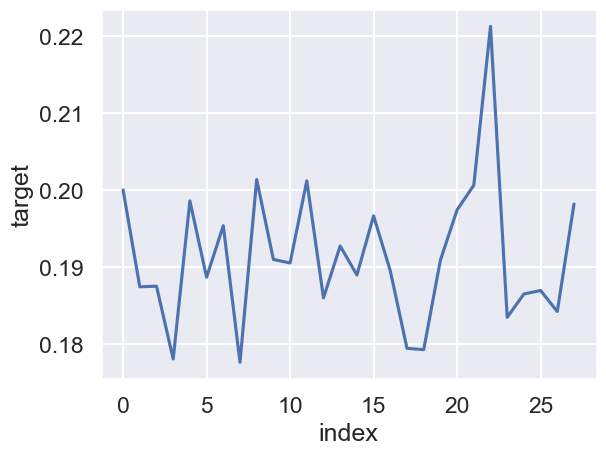

In [32]:
sns.lineplot(
    data = res,
    x="index",
    y="target"
);

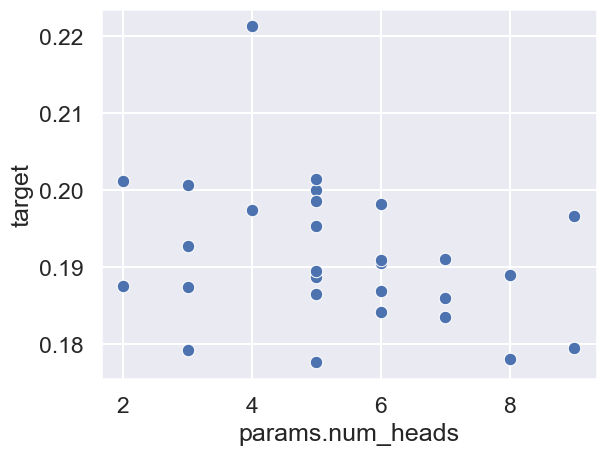

In [145]:
sns.scatterplot(
    data = res,
    x="params.num_heads",
    y="target"
);

In [33]:
min_idx = res["target"].argmin()
max_idx = res["target"].argmax()

res.loc[min_idx]

index                     7.000000
target                    0.177688
params.encoder_dropout    0.100000
params.n_blocks           9.000000
params.num_heads          5.000000
params.upscale_factor     0.800000
Name: 7, dtype: float64

In [34]:
res.loc[max_idx]

index                     22.000000
target                     0.221264
params.encoder_dropout     0.300000
params.n_blocks            6.000000
params.num_heads           4.000000
params.upscale_factor      1.600000
Name: 22, dtype: float64

In [38]:
res.sort_values("target")

,index,target,params.encoder_dropout,params.n_blocks,params.num_heads,params.upscale_factor
7,7,0.177688,0.1,9,5,0.8
3,3,0.178120,0.1,4,8,2.0
18,18,0.179324,0.0,8,3,1.5
17,17,0.179500,0.3,3,9,1.2
23,23,0.183522,0.1,2,7,1.3
26,26,0.184269,0.0,2,6,1.2
12,12,0.186042,0.2,2,7,1.6
24,24,0.186545,0.1,4,5,1.1
25,25,0.186993,0.3,3,6,1.9
1,1,0.187480,0.2,5,3,1.5


In [142]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

mod = make_pipeline(
    #StandardScaler(),
    PolynomialFeatures(),
    LinearRegression()
    #LassoCV(max_iter=10000)
)

#mod = LinearRegression()
mod.fit(res.drop(["index", "target"], axis=1), res["target"])
mod.score(res.drop(["index", "target"], axis=1), res["target"])

0.46858542733626285

In [151]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

mod = make_pipeline(
    #StandardScaler(),
    PolynomialFeatures(),
    LinearRegression()
    #LassoCV(max_iter=10000)
)

#mod = LinearRegression()
mod.fit(res[["params.n_blocks", "params.num_heads"]], res["target"])
mod.score(res[["params.n_blocks", "params.num_heads"]], res["target"])

0.27998390322137734

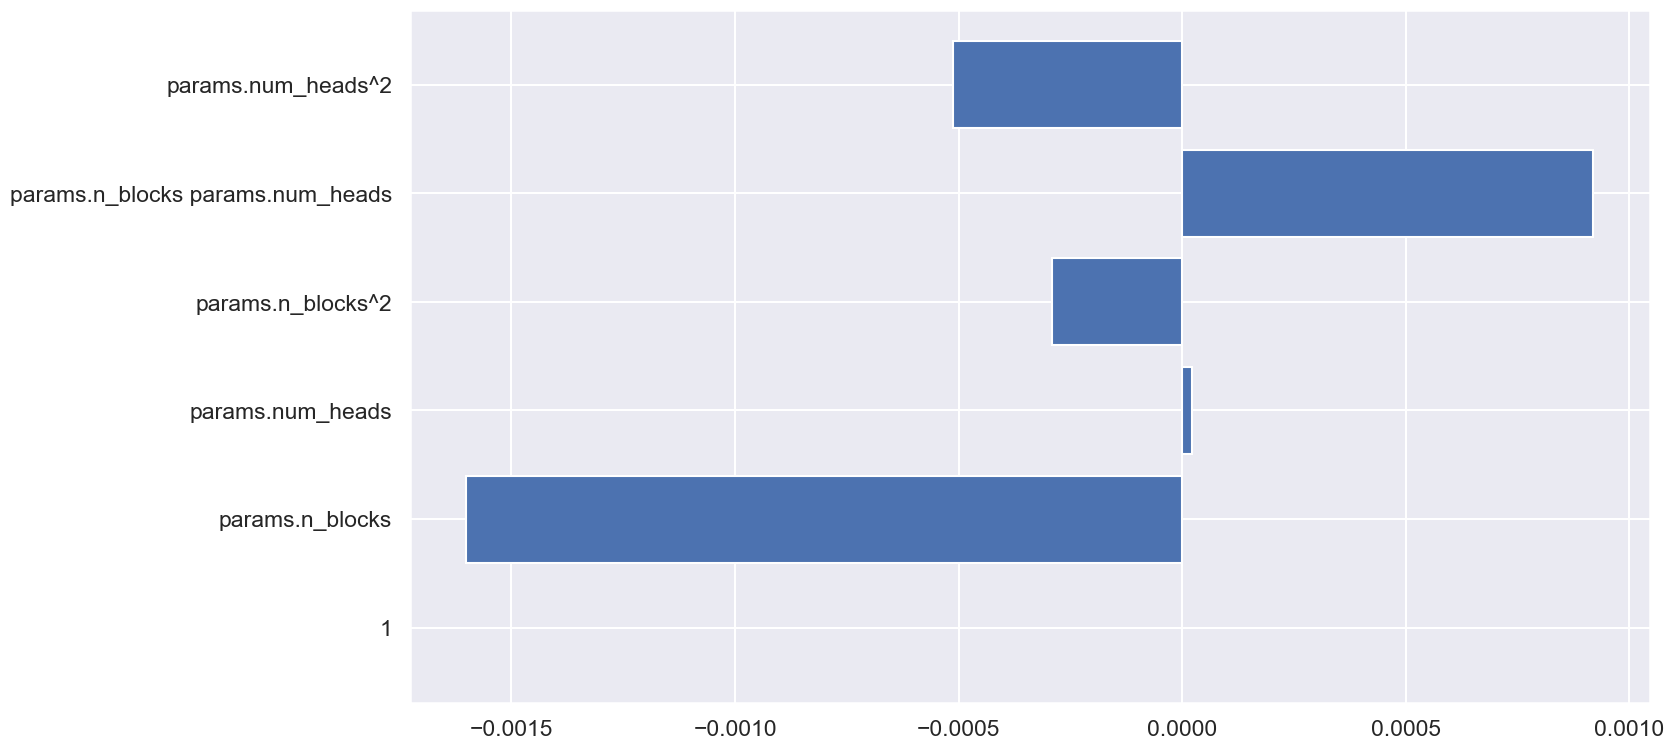

In [152]:
plt.figure(figsize=(16, 9))
plt.barh(mod[-2].get_feature_names_out(), mod[-1].coef_);

In [153]:
for i, value in enumerate(mod[-1].coef_):
    if value == 0:
        continue
    print(mod[-2].get_feature_names_out()[i], value)

params.n_blocks -0.001601800630022361
params.num_heads 2.1182698938103745e-05
params.n_blocks^2 -0.00029097036276266213
params.n_blocks params.num_heads 0.0009191051733391711
params.num_heads^2 -0.0005128372681078985


In [136]:
from scipy.optimize import minimize

def bb_func(x:list[float]) -> float:
    n_blocks, num_heads = x
    return -(0.0006323491514341179*n_blocks*num_heads -0.000284146070872384 * n_blocks**2 -0.0003890479981989297 * num_heads**2)

minimize(bb_func, x0=[10,10], method="BFGS")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.840971053818438e-09
        x: [-1.819e-02 -1.331e-02]
      nit: 14
      jac: [-1.920e-06  1.145e-06]
 hess_inv: [[ 1.609e+04  1.326e+04]
            [ 1.326e+04  1.220e+04]]
     nfev: 66
     njev: 22

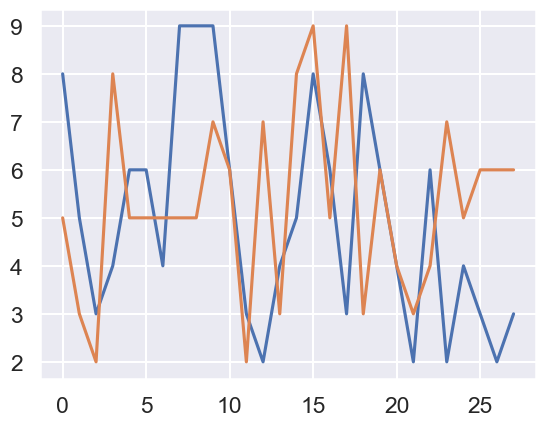

In [35]:
plt.plot(
    res["params.n_blocks"],
);
plt.plot(
    res["params.num_heads"]
);